In [7]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
base_dir = "C:/Users/SANJAY KUMAR/Documents/Projects/Major/Dataset/Flicker8k_Dataset"
work_dir = "C:/Users/SANJAY KUMAR/Documents/Projects/Major"

In [48]:
#Model for Feature Extraction

In [4]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Extracting features of images

In [6]:
features = {}
dir = os.path.join(base_dir)

for img_name in tqdm(os.listdir(dir)) :
    img_path = dir + '/' + img_name
    img = load_img(img_path, target_size=(224,224))
    img = img_to_array(img)
    img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img = preprocess_input(img)
    feature = model.predict(img, verbose=0)
    img_id = img_name.split('.')[0]
    features[img_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [8]:
# Save the extracted features.

pickle.dump(features, open(os.path.join(work_dir, 'features_2.pkl'), 'wb'))

In [5]:
# Loading the features.

with open(os.path.join("C:/Users/SANJAY KUMAR/Documents/Projects/Major","features_2.pkl"), 'rb') as f:
    features = pickle.load(f)

In [19]:
list(features.items())[0:5]

[('1000268201_693b08cb0e',
  array([[2.5076473, 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ]], dtype=float32)),
 ('1001773457_577c3a7d70',
  array([[0.        , 0.        , 0.49410743, ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('1002674143_1b742ab4b8',
  array([[1.4937081, 0.       , 0.5356841, ..., 2.315414 , 3.7418418,
          0.       ]], dtype=float32)),
 ('1003163366_44323f5815',
  array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)),
 ('1007129816_e794419615',
  array([[0.        , 0.09227565, 0.        , ..., 0.        , 0.        ,
          0.06529307]], dtype=float32))]

In [6]:
len(features)

8091

In [18]:
#loading captions

In [22]:
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [23]:
captions_doc = load_doc("C:/Users/SANJAY KUMAR/Documents/Projects/Major/Dataset/Flickr8k_text/Flickr8k.token.txt")

In [24]:
len(captions_doc)

3394868

In [35]:
# Mapping Images with Captions

In [25]:
mapping = {}
for line in tqdm(captions_doc.split('\n')) :
    t = line.split("\t")
    image_id, caption = t[0], t[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping :
        mapping[image_id] = []
    mapping[image_id].append(caption)
del mapping['']

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
len(mapping)

8091

In [ ]:
#Preprocessing

In [26]:
def cleaning(mapping) :
    for key, captions in mapping.items() :
        for i in range(len(captions)) :
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]','')
            caption = caption.replace('\s+',' ')
            caption = 'start ' + " ".join([word for word in caption.split() if len(word)>1]) + ' end'
            captions[i] = caption

In [27]:
cleaning(mapping)

In [29]:
list(mapping.items())[0:3]

[('1000268201_693b08cb0e',
  ['start child in pink dress is climbing up set of stairs in an entry way end',
   'start girl going into wooden building end',
   'start little girl climbing into wooden playhouse end',
   'start little girl climbing the stairs to her playhouse end',
   'start little girl in pink dress going into wooden cabin end']),
 ('1001773457_577c3a7d70',
  ['start black dog and spotted dog are fighting end',
   'start black dog and tri-colored dog playing with each other on the road end',
   'start black dog and white dog with brown spots are staring at each other in the street end',
   'start two dogs of different breeds looking at each other on the road end',
   'start two dogs on pavement moving toward each other end']),
 ('1002674143_1b742ab4b8',
  ['start little girl covered in paint sits in front of painted rainbow with her hands in bowl end',
   'start little girl is sitting in front of large painted rainbow end',
   'start small girl in the grass plays with fi

In [ ]:
#Merging all captions into single list

In [30]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [31]:
len(all_captions)

40455

In [34]:
all_captions[0:20]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end',
 'start little girl covered in paint sits in front of painted rainbow with her hands in bowl end',
 'start little girl is sitting in front of large painted rainbow end',
 'start small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it end',
 'start there is girl with pigtails sitting in fro

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [17]:
max_length = max(len(caption.split()) for caption in all_captions)
print(max_length)

34


In [ ]:
#Train Test Split

In [18]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.80)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
#Building the Model

In [24]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

model = Model(inputs=[inputs1,inputs2], outputs=outputs)

In [25]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      2171648     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
#Training the model

In [27]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [31]:
epochs = 20
batch_size = 32
steps = len(train)//batch_size
for i in range(epochs) :
    generator = data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

202/202 [==============================] - 458s 2s/step - loss: 2.1907


In [ ]:
model.save(work_dir +'/second_model.h5')

In [21]:
model1 = load_model("C:/Users/SANJAY KUMAR/Documents/Projects/Major/Code/second_model.h5")

In [ ]:
#Testing the Model

In [22]:
import math
import re
from collections import Counter
WORD = re.compile(r"\w+")
def find_cosine(t1,t2) :
    def get_cosine(vec1, vec2):
        intersection = set(vec1.keys()) & set(vec2.keys())
        numerator = sum([vec1[x] * vec2[x] for x in intersection])

        sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
        sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
        denominator = math.sqrt(sum1) * math.sqrt(sum2)

        if not denominator:
            return 0.0
        else:
            return float(numerator) / denominator

    def text_to_vector(text):
        words = WORD.findall(text)
        return Counter(words)
    
    vector1 = text_to_vector(t1)
    vector2 = text_to_vector(t2)

    cosine = round(get_cosine(vector1, vector2)*100)

    #print("Cosine:", cosine)
    return cosine

In [23]:
def index_to_word(integer,tokenizer) :
    for word, index in tokenizer.word_index.items() :
        if index == integer :
            return word
    return None

In [24]:
def predict_caption(model, image, tokenizer, max_length) :
    in_text = 'start'
    for i in range(max_length) :
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq],max_length)
        nextword = model.predict([image,seq],verbose=0)
        nextword = np.argmax(nextword)
        word = index_to_word(nextword,tokenizer)
        if word is None :
            break
        in_text += " "+ word
        if word == 'end' :
            break
    return in_text

In [68]:
cosine = 0
accuracy = 0.0
for key in tqdm(test) :
    captions = mapping[key]
    predicted = predict_caption(model1,features[key],tokenizer,max_length)
    all_caption = [caption.split(',') for caption in captions]
    for caption in all_caption :
        cosine = max(cosine,round(find_cosine(caption[0][6:-4],predicted[6:-4])))
    accuracy += cosine
print(accuracy/1619.0)

  0%|          | 0/1619 [00:00<?, ?it/s]

91.65657813465101


In [ ]:
#Checking the results

In [27]:
def generate_caption(image_name) :
    image_id = image_name.split('.')[0]
    img_path = base_dir+ '/' + image_name
    image = Image.open(img_path)
    captions = mapping[image_id]
    print("---------------------Actual-------------")
    for caption in captions :
        print(caption)
    pred = predict_caption(model1,features[image_id],tokenizer,max_length)
    print("------------------Predicted---------------")
    print(pred)
    plt.imshow(image)

---------------------Actual-------------
start man in swim trunks and red life vest jet skiing end
start man waterskiing with one hand end
start man wearing red life jacked is holding purple rope while waterskiing end
start man wearing swimming trunks is waterskiing backwards using only one hand end
start person in red ski jacket skiing backwards end
------------------Predicted---------------
start two men wakeboarding on the beach end


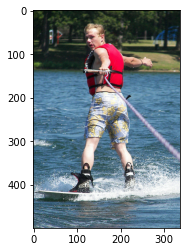

In [31]:
generate_caption('172097782_f0844ec317.jpg')

In [ ]:
#Testing with Other images

In [13]:
vgg_model = VGG16()
vgg_model = Model(inputs = vgg_model.inputs, outputs=vgg_model.layers[-2].output)

'start man in jeans jacket is riding bike down the road end'

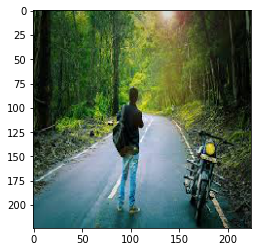

In [34]:
image_path = 'C:/Users/SANJAY KUMAR/Documents/Projects/Major/Test_images/img9.jpeg'
image = load_img(image_path,target_size=(224,224))
plt.imshow(image)
img = img_to_array(image)
img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
img = preprocess_input(img)
feature = vgg_model.predict(img,verbose=0)
predict_caption(model1,feature,tokenizer,max_length)